# Working with Item Dependencies and Data Sources

## Introduction

In [1]:
from arcgis.gis import GIS
from arcgis.apps.itemgraph import ItemGraph, create_dependency_graph
gis = GIS(profile="your_online_profile")

Versions 2.4.0 and 2.4.1 of the ArcGIS API for Python introduced some very handy functionality for content management workflows: the [`arcgis.apps.itemgraph`](/python/latest/api-reference/arcgis.apps.itemgraph.html) module and the [`item.remap_data()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.remap_data) function. The primary goals of this added functionality: 
* provide the ability to understand what organizational items need in order to exist
* understand how organizational items relate to one another
* update organizational items with invalid components

The [`itemgraph`](/python/latest/api-reference/arcgis.apps.itemgraph.html) module accomplishes these first two goals. The classes and functions in this module allow a user to create a directional graph documenting the relationships between different items in an organization- starting with a root item, you'll be able to see all of the items it needs to exist, all of the items that those items need to exist, and so on. 

The [`remap_data()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.remap_data) method accomplishes the third goal. Say you have a complex application- once you know an item's dependencies, you can easily change or fix one. Additionally, if you have knowledge of the structure of your app, you can use this function to fix other components of it as well.

Using these functions and methods in conjunction is a powerful combination, and we'll go over a basic but important workflow that leverages both of them.

## The `arcgis.apps.itemgraph` Module

### What is a Dependency?

We'll start by examining 2 classes and a function that center around a core concept: creating a dependency graph that allows users to examine how items relate to each other in their ArcGIS Online or Enterprise organizations. As mentioned above, these graphs inform us what items are required for other items to exist, and encompass the full range of dependency types for items. 

Before we dive a bit deeper into it, let's briefly go over a handful of the ways an item can be part of another item. There are many different [item types](/rest/users-groups-and-items/items-and-item-types/) in the ArcGIS universe, and the ways they store and use data vary greatly; some are based on JSON structures, some are based on hosted services, and others on a variety of common (or uncommon) file types. Items can use other items in a wide range of ways, such as:
- source files for published layers (e.g., File GDB -> Feature Layer)
- visual components in a web-based app (e.g., a Web Map found in a StoryMap)
- attachments to other items (e.g., a Microsoft Word template in a Survey123 application)

### Class Breakdown

[The documentation for the module can be found here](/python/latest/api-reference/arcgis.apps.itemgraph.html).

Let's break down the 4 things we see in the doc:

#### [`ItemGraph`](/python/latest/api-reference/arcgis.apps.itemgraph.html#itemgraph)
  
The `ItemGraph` is the main structure that a user will be working with. It is built on top of [NetworkX's DiGraph class](https://networkx.org/documentation/stable/reference/classes/digraph.html), meaning it also gets access to all of NetworkX's DiGraph and Graph functionality. An `ItemGraph` is populated with instances of `ItemNode`, and can be created from scratch via `create_dependency_graph()` or from a priorly saved `ItemGraph` via `load_from_file`.

#### [`ItemNode`](/python/latest/api-reference/arcgis.apps.itemgraph.html#itemnode)

An `ItemNode` is an object that pertains to an indexed item/dependency. The node's `.id` property is an item's id, or a service's url. In the case of nodes with a valid `Item` object in the org tied to the item id, that [`Item`](/python/latest/api-reference/arcgis.gis.toc.html#item) object will be stored as the node's `.item` property. The `ItemNode` class has functions on it that allow a user to see an item's dependencies stored in the graph going in either direction, initial-level or recursive.

#### [`create_dependency_graph()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#create-dependency-graph)

This is the main function that a user will use to construct an `ItemGraph`. Users feed in a list of `Item` objects or item id/url strings, and the function will recursively dissect any items or dependent items found and add everything to one `ItemGraph` returned back to a user. Users have the option to include items referenced from outside organizations in their graph, but these outside org items will not be explored for further dependencies. Additionally, for certain items that have reverse dependencies documented through their [`related_items()`](/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.related_items) function, users have the option to include those in the graph as well.

#### [`load_from_file()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#load-from-file)

This is the alternative way to create an `ItemGraph`. When working with a graph, users have the option to write it out to a saved [GML file format](https://networkx.org/documentation/stable/reference/readwrite/gml.html) via the [`write_to_file()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemGraph.write_to_file) method. GML is a format commonly used for saving/loading graphs between graphing libraries. Passing in an `ItemGraph` GML file to this function will reconstruct a graph with the same ID's and relationships. Users have the option to populate each `ItemNode` with item objects, or leave them strictly with ID's/relationships for the sake of performance (which is good when loading in a graph with thousands of items). We won't cover this function in this guide, but please refer to this [sample](/python/latest/samples/org-wide-dependency-graph) for an advanced workflow demonstrating it.

Now that we know the basics of the code, let's jump into it. We'll use `create_dependency_graph()` to create an `ItemGraph`, then examine  `ItemNode` instances in the graph to learn what our org items contain, are contained by, require to exist, and are required by to exist. We'll start with a Survey123 item.

In [4]:
# first, grab a survey to see everything that is required for it to exist
survey_id = "02d0702e1ef0468083f780791670c969"
survey = gis.content.get(survey_id)
graph = create_dependency_graph(gis, [survey])
graph

Calling [`ItemGraph.all_items()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemGraph.all_items) lets a user see all of the items in the graph. One important thing to note: with this function, as well as the `ItemNode` functions that return dependencies, a user can elect to return the items in "item" form, "id" form, or "node" form (the default) by specifiying an `out_format` argument:

In [5]:
graph.all_items(out_format="item")

[<Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings_results" type:Feature Layer Collection owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings" type:Feature Layer Collection owner:nparavicini_geosaurus>,
 <Item title:"summary_individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"individual_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"Topographic" type:Web Map owner:esri_en>,
 <Item title:"summary_temp" type:Microsoft Word owner:nparavicini_geosaurus>,
 <Item title:"San Diego Parrot Sightings_form" type:Feature Layer Collection owner:nparavicini_geosaurus>]

Let's grab and inspect an `ItemNode` instance by calling the [`ItemGraph.get_node()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemGraph.get_node) method.

In [6]:
# now, let's grab a node and examine the structure
survey_node = graph.get_node(survey_id)
survey_node

ItemNode(id: 02d0702e1ef0468083f780791670c969, item: San Diego Parrot Sightings)

<Item title:"San Diego Parrot Sightings" type:Form owner:nparavicini_geosaurus>
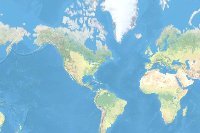

In [7]:
# we can see the item attached to the node if we want
survey_node.item

Now we'll examine dependencies of specific nodes.

In [7]:
# contains() = items immediately used/referenced by the survey item
survey_node.contains()

[ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: d818128edbab44099238bc44e4bf2df0, item: summary_individual_temp),
 ItemNode(id: 447ef32f6431488c9f9d7552f7d20ce0, item: individual_temp),
 ItemNode(id: 588f0e0acc514c11bc7c898fed9fc651, item: Topographic),
 ItemNode(id: 6a5d407b62954806ac31558c6774656f, item: summary_temp),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form)]

In [14]:
# requires() = every item needed for the survey to exist
survey_node.requires()

[ItemNode(id: 6a5d407b62954806ac31558c6774656f, item: summary_temp),
 ItemNode(id: 588f0e0acc514c11bc7c898fed9fc651, item: Topographic),
 ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: 41dd3cca32914cc7ae8fd3a727f44e17, item: San Diego Parrot Sightings),
 ItemNode(id: 447ef32f6431488c9f9d7552f7d20ce0, item: individual_temp),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form),
 ItemNode(id: d818128edbab44099238bc44e4bf2df0, item: summary_individual_temp)]

In [12]:
# conversely, we can grab a dependent item and see what items immediately contain it and need it to exist
result_flayer = graph.get_item("41dd3cca32914cc7ae8fd3a727f44e17")
result_flayer.item

<Item title:"San Diego Parrot Sightings" type:Feature Layer Collection owner:nparavicini_geosaurus>

In [10]:
# contained_by() = items in the graph that immediately use/reference this feature layer item
result_flayer.contained_by()

[ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form)]

In [9]:
# required_by() = every item in the graph that needs this feature layer item to exist
result_flayer.required_by()

[ItemNode(id: 9fccd6b78482414994eb2c19f90a44c8, item: San Diego Parrot Sightings_form),
 ItemNode(id: a7192e06cfb446e1bab59849285e1038, item: San Diego Parrot Sightings_results),
 ItemNode(id: 02d0702e1ef0468083f780791670c969, item: San Diego Parrot Sightings)]

An important thing to remember is that `create_dependency_graph()` finds relationships from the top down, so [`contained_by()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemNode.contained_by) and [`required_by()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemNode.required_by) will only show items that have been analyzed along the way from our root node(s)- they're not a full picture of _every_ item in the organization that may contain or require a specific item, just the ones contained under the umbrella of our original item. However, [`contains()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemNode.contains) and [`requires()`](/python/latest/api-reference/arcgis.apps.itemgraph.html#arcgis.apps.itemgraph.ItemNode.requires) do indeed show every item in an org that are contained or required by a given item.

To get the full, org-wide picture with `contained_by()` or `required_by()`, a graph would need to be made with every item in the organization. See [this sample](/python/latest/samples/org-wide-dependency-graph) for a guide on how to create and manage that type of graph.

### The `Item.remap_data()` Function

[The documentation for this function can be found here.](https://developers.arcgis.com/python/latest/api-reference/arcgis.gis.toc.html#arcgis.gis.Item.remap_data)

We've covered functionality that can identify items contained within other items- now let's take a look at functionality that can automate replacement of those items, or fix other parts of an application's structure. `remap_data()` is a powerful tool for working with your JSON-based applications in the ArcGIS system. At its core, it allows you to swap out data sources within your item's JSON structure. Say you have multiple layers in a webmap you want to swap out, or a map present in a StoryMap- all you have to do is construct a replacement dictionary mapping your old item ID's to your new ones, and it will replace them, both in the draft and published versions of your app.

When the `force` parameter is set to `False` (the default), some validation occurs under the hood. The function ensures that both items exist in the GIS organization, and that they're of the same type, to retain a valid configuration of the application. However, setting `Force` to `True` gives you more power, at the risk of altering the underlying structure without validation. You can use it to replace item ID's that no longer exist in the organization, change the name of something throughout the app, fix a typo, etc. It uses a regular expression to identify and replace instances of strings, so it will pick things up wherever they are in the structure.

Let's look at a basic example of it in action. We'll examine the JSON of an application we're working with to note the effects.

In [14]:
basic_map = gis.content.get("a9ace97e3fdc415d943675d5ba75901e")
old_json = basic_map.get_data()
old_json

{'operationalLayers': [{'id': '197e871ef5d-layer-2',
   'title': 'USA_Major_Cities',
   'url': 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/USA_Major_Cities_94522/FeatureServer/0',
   'itemId': 'ad8ead0c99044b94aef1d5a364e6629c',
   'layerType': 'ArcGISFeatureLayer',
   'popupInfo': {'popupElements': [{'type': 'fields'},
     {'type': 'attachments', 'displayType': 'auto'}],
    'showAttachments': True,
    'fieldInfos': [{'fieldName': 'FID',
      'isEditable': False,
      'label': 'FID',
      'visible': False},
     {'fieldName': 'NAME',
      'isEditable': True,
      'label': 'NAME',
      'visible': True},
     {'fieldName': 'AGE_10_14',
      'format': {'digitSeparator': True, 'places': 0},
      'isEditable': True,
      'label': 'AGE_10_14',
      'visible': True},
     {'fieldName': 'AGE_15_19',
      'format': {'digitSeparator': True, 'places': 0},
      'isEditable': True,
      'label': 'AGE_15_19',
      'visible': True},
     {'fieldName': 'AGE_20_

Now, let's look what happens when we run `remap_data()` to replace the layer in our map with a different one. We'll compare some of the new layer values with the old.

In [15]:
basic_map.remap_data({"ad8ead0c99044b94aef1d5a364e6629c" : "2113d04eade0432784e8edd336193e68"})
new_json = basic_map.get_data()

for key in ["itemId", "title", "url"]:
    old_value = old_json['operationalLayers'][0][key]
    new_value = new_json['operationalLayers'][0][key]
    print(f"Old: {old_value}, New: {new_value}")

Old: ad8ead0c99044b94aef1d5a364e6629c, New: 2113d04eade0432784e8edd336193e68
Old: USA_Major_Cities, New: CA/OR Airports
Old: https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/USA_Major_Cities_94522/FeatureServer/0, New: https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/ad363a_87e5a/FeatureServer/0


### Putting it Together

Now that we've seen how these things work, let's see how we can use them to speed up what might be an otherwise time-consuming workflow.

Put yourself in the shoes of an admin that has been tasked with the process of migrating items to a new portal. Before migrating, you want to ensure that all of your items (such as your complex apps) are rendering correctly and not missing any data sources, but don't want to manually click through each one and/or their drafts. How can we more efficiently find out what's missing?

We can create a dependency graph, and then look at which item ID's within the graph don't correspond to existent or accessible items. Let's show a quick example of this by looking at a StoryMap with some broken pieces within it, and show how easy it is to detect and fix it. 

In [26]:
# the dependency construction will look for all item id's, but won't retrieve items from broken id's or outside org items
storymap = gis.content.get("fd5801d2f66b43e1a20146d8761f758b")
graph2 = create_dependency_graph(gis, [storymap])
graph2.all_items()

[ItemNode(id: fd5801d2f66b43e1a20146d8761f758b, item: Oh heavens),
 ItemNode(id: faa67b0af7914a2f9f4d96c561816c6e),
 ItemNode(id: 35983e54e61a40b8ac03148e197452ac, item: PLACES: Arthritis),
 ItemNode(id: 3b7221d4e47740cab9235b839fa55cd7, item: PLACES: Local Data for Better Health),
 ItemNode(id: 7099b3c2e979415e975d00e58afed77e, item: Map that should totally work),
 ItemNode(id: baaf98d1695f47db8d5dc701c0e5f864, item: Read-Only CA/OR Airports),
 ItemNode(id: 0384ujr43n53490890843t543ojf809re)]

We can see that there are certain nodes in our graph that don't have items attached to them. This means that there are dependencies that won't render anything in our apps, meaning they're broken and should be replaced. Let's isolate them.

Just to relate it visually, let's see what the two problematic webmaps in our StoryMap look like.
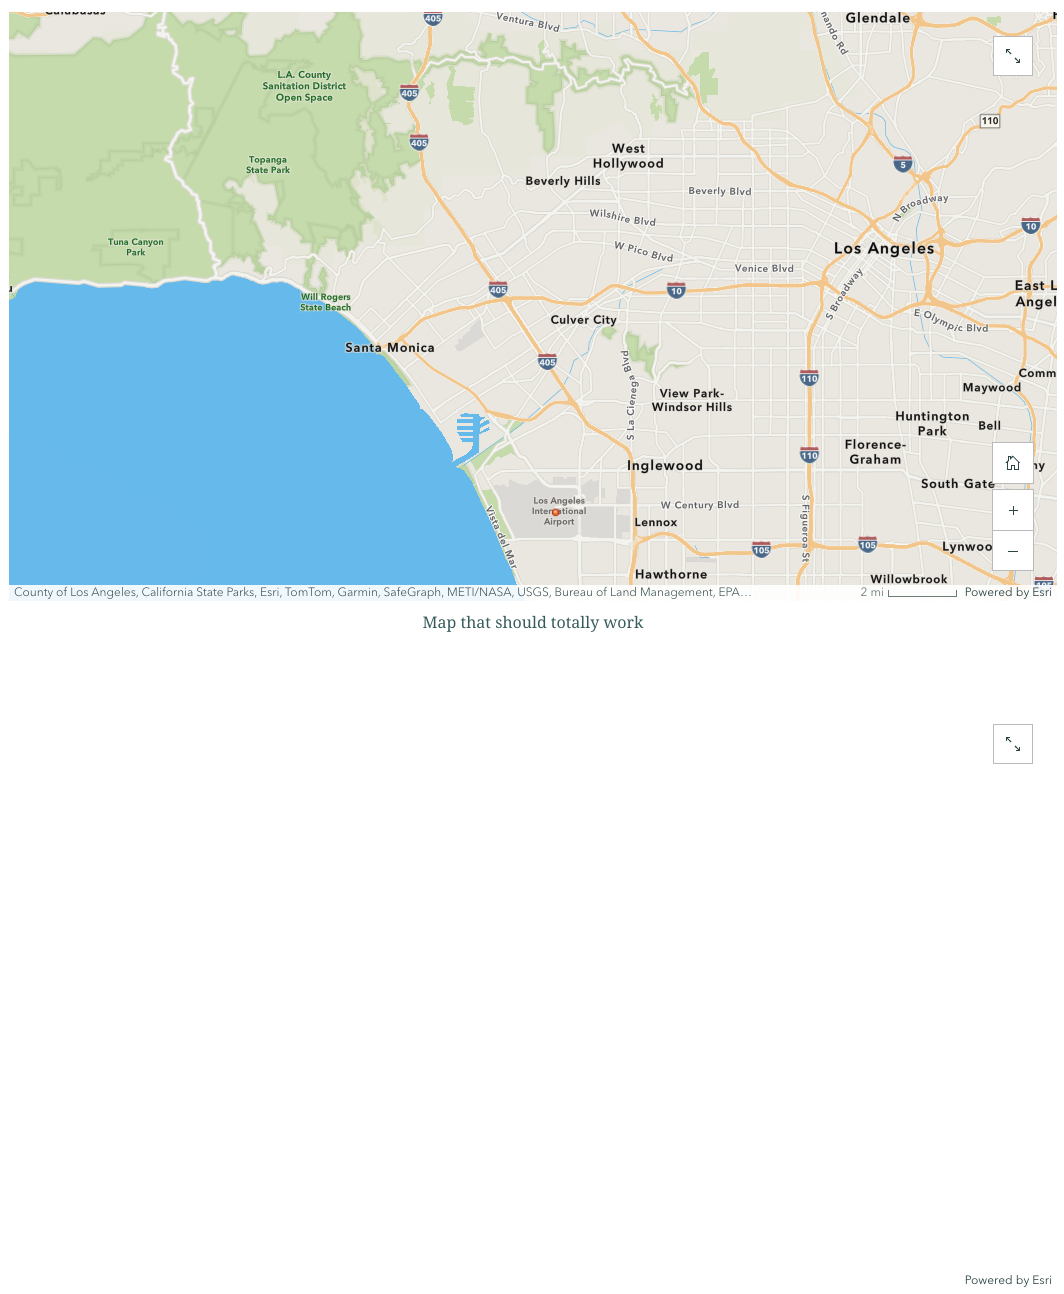

In [27]:
# note how some of these items don't have items attached
# that means they're inaccessible in this org or don't exist
for node in graph2.all_items():
    if node.item == None:
        print(node.id)

faa67b0af7914a2f9f4d96c561816c6e
0384ujr43n53490890843t543ojf809re


We can do a little magic with matplotlib to visualize where these items are present and figure out which apps we need to replace them in.

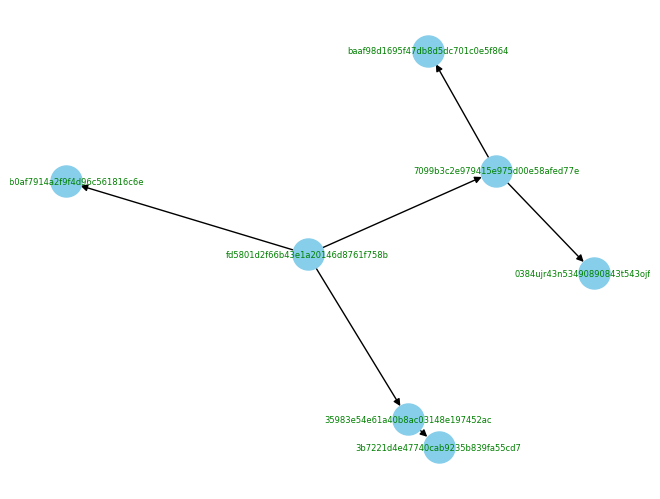

In [28]:
# let's visualize how they fit into the graph to see what we need to fix
# we can do this by employing matplotlib and networkx
import matplotlib.pyplot as plt
import networkx as nx
pos = nx.spring_layout(graph2)  # positions for all nodes
nx.draw(graph2, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=6, font_color="green")
nx.draw_networkx_labels(graph2, pos, labels=nx.get_node_attributes(graph2, 'label'))

# Show the plot
plt.show()

<Item title:"Map that should totally work" type:Web Map owner:nparavicini_geosaurus>
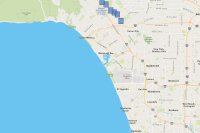

In [29]:
# so we can see that one of them is from our root item, and one is from a dependent item
# let's see what that sub item is
sub_node = graph2.get_item("7099b3c2e979415e975d00e58afed77e")
webmap = sub_node.item
webmap

With some suitable replacements for our broken data sources, we can call `remap_data()` on the apps that contain them.

In [30]:
# now that we know where our two problematic id's exist, we can replace them and fix our storymap
# we can use the item class's remap_data() function to easily do this. let's identify some replacements
bad_layer_id = "0384ujr43n53490890843t543ojf809re"
bad_webmap_id = "faa67b0af7914a2f9f4d96c561816c6e"
new_layer_id = "55c85385338d434ba1194d9b2c2a60c8"
new_webmap_id = "865ec0112fde477788c4f51c4a7baae6"
# we call remap_data() on the item containing the dependencies to be swapped
storymap.remap_data({bad_webmap_id : new_webmap_id}, force = True)
webmap.remap_data({bad_layer_id : new_layer_id}, force = True)

True

In [31]:
# now, we can make a new graph from the storymap and see if everything looks right
graph2_updated = create_dependency_graph(gis, [storymap])
graph2_updated.all_items()

[ItemNode(id: fd5801d2f66b43e1a20146d8761f758b, item: Oh heavens),
 ItemNode(id: 865ec0112fde477788c4f51c4a7baae6, item: clone map different layer id),
 ItemNode(id: 2113d04eade0432784e8edd336193e68, item: CA/OR Airports),
 ItemNode(id: 35983e54e61a40b8ac03148e197452ac, item: PLACES: Arthritis),
 ItemNode(id: 3b7221d4e47740cab9235b839fa55cd7, item: PLACES: Local Data for Better Health),
 ItemNode(id: 7099b3c2e979415e975d00e58afed77e, item: Map that should totally work),
 ItemNode(id: baaf98d1695f47db8d5dc701c0e5f864, item: Read-Only CA/OR Airports),
 ItemNode(id: 55c85385338d434ba1194d9b2c2a60c8, item: polygons),
 ItemNode(id: d3a24f71ee864118968fa24e572c6dc2, item: polygons)]

And finally, let's see what our the maps in our StoryMap look like, just to confirm what we did through automation. Tada!
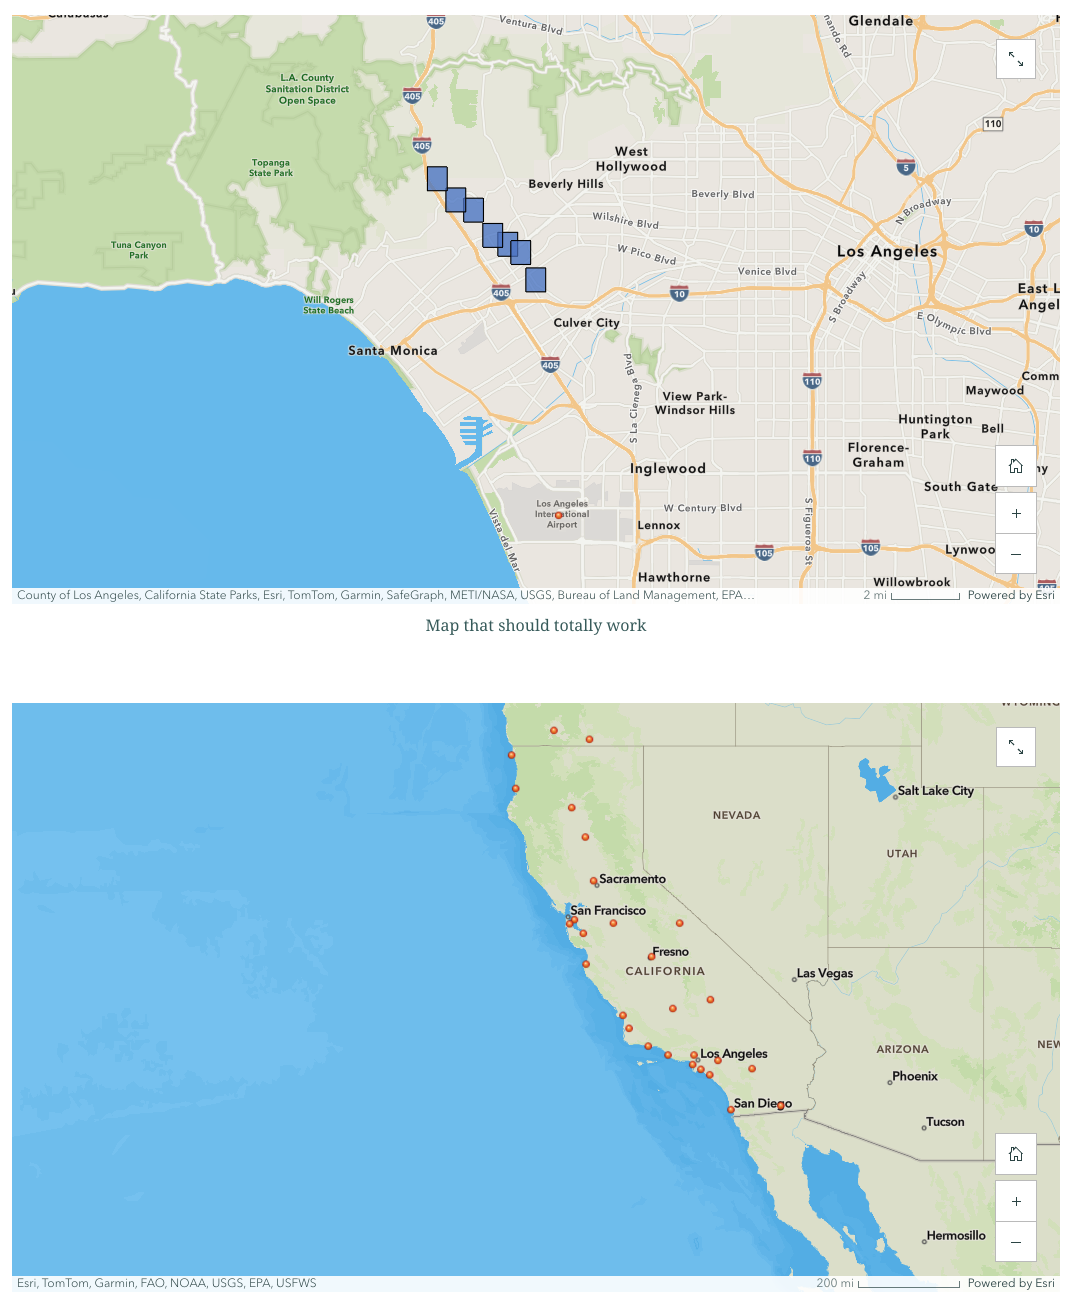